In [1]:
import numpy as np
import pandas as pd

In [2]:
import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

# 1 Scenario Generator

In [3]:
def scenario_generator(start_year, simulation_window):
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    historic_demand_maize   = [1000000, 1100000, 1250000, 1400000, 1500000]        # demand at t=0
    
    # Growth scenario
    #predefined_demand_maize = [1600000, 1900000, 1900000, 1950000, 2000000, 2100000, 2150000, 2200000, 
    #                           2200000, 2250000, 2350000, 2400000, 2450000, 2550000, 2700000, 2900000, 
    #                           3000000, 3050000, 3150000, 3300000]
    
    # Erratic growth scenario
    #predefined_demand_maize = [1705000, 1883000, 1835000, 2090000, 2093000, 2100000, 2047000, 2341000, 
    #                           2549000, 2522000, 2670000, 2795000, 2717000, 2631000, 2561000, 2673000, 
    #                           2878000, 3105000, 3342000, 3323000]
    
    # Crisis scenario
    predefined_demand_maize = [1600000, 1900000, 1900000, 1950000, 1750000, 1600000, 1550000, 1530000, 
                               1570000, 1620000, 1700000, 1750000, 1800000, 1900000, 2050000, 2250000, 
                               2350000, 2400000, 2500000, 2650000]

    # Soybean - Exponential demand
    historic_demand_soybean = 5*[0]
    rate_soybean = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    historic_demand_wheat = 5*[0]
    rate_wheat  = 1.02
    mu_wheat    = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat = 0.065         # standard deviation of bonus rate (% points)   - input for random method

    # Create demand scenario
    #maize.linear_scenario      (start_year, simulation_window, historic_demand_maize  , growth_maize)
    maize.predefined_scenario   (start_year, simulation_window, historic_demand_maize  , predefined_demand_maize)
    soybean.exponential_scenario(start_year, simulation_window, historic_demand_soybean, rate_soybean)
    wheat.random_scenario       (start_year, simulation_window, historic_demand_wheat  , rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(vessels, commodities, simulation_window)

    # Plot forecast
    visualisation.scenario(commodities, simulation_window, start_year)
    
    return vessels, commodities

# 2 Simulator

In [4]:
def simulate(terminal, occupancy_trigger, WACC, vessels, commodities, start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year

        ######################
        # Investment Decisions
        ######################           
        
        # Berths and cranes
        allowable_berth_occupancy = occupancy_trigger
        terminal.berths, terminal.cranes = invest.berth_invest_decision(terminal.berths, terminal.cranes, vessels, allowable_berth_occupancy, year, timestep, operational_hours)
        
        # Quay
        terminal.quays = invest.quay_invest_decision(terminal.quays, terminal.berths, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        terminal.storage = invest.storage_invest_decision(terminal.storage, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        terminal.stations = invest.station_invest_decision(terminal.stations, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        terminal.quay_conveyors = invest.quay_conveyor_invest_decision(terminal.quay_conveyors, terminal.cranes, year, timestep, operational_hours)
        terminal.hinterland_conveyors = invest.hinterland_conveyor_invest_decision(terminal.hinterland_conveyors, terminal.stations, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        terminal = financial.throughput_calc(terminal, vessels, commodities, allowable_berth_occupancy, year, timestep, operational_hours)
        # Revenues
        terminal.revenues = financial.revenue_calc(terminal.revenues, terminal.throughputs, commodities, year, timestep)
        # Capex
        terminal.capex = financial.capex_calc(terminal, year, timestep)
        # Labour costs
        terminal.labour = financial.labour_calc(terminal, year, timestep, operational_hours)
        # Maintenance costs
        terminal.maintenance = financial.maintenance_calc(terminal, year, timestep)
        # Energy costs
        terminal.energy = financial.energy_calc(terminal, year, operational_hours, timestep)
        # Insurance costs
        terminal.insurance = financial.insurance_calc(terminal, year, timestep)
        # Lease costs 
        terminal.lease = financial.lease_calc(terminal, year,timestep)
        # Demurrage costs
        terminal.demurrage = financial.demurrage_calc(terminal.demurrage, terminal.berths, vessels, year, timestep)
        # Residual value calculations 
        terminal.residuals = financial.residual_calc(terminal, year, timestep)
        # Profits
        terminal.profits = financial.profit_calc(terminal, simulation_window, timestep, year, start_year)
        # Opex
        terminal.opex = financial.opex_calc(terminal, year, timestep)      
        
    #WACC depreciated profits
    terminal.WACC_cashflows = financial.WACC_calc(WACC, terminal.profits, simulation_window, start_year)

    # Combine all cashflows
    terminal.cashflows = financial.cashflow_calc(terminal, simulation_window, start_year) 
    
    #NPV 
    terminal.NPV = financial.NPV_calc(terminal.WACC_cashflows)
            
    return terminal

# 3 Investment Triggers Iteration

In [5]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years
end_year          = start_year + simulation_window - 1
operational_hours = 4680   # operational hours per year
allowable_occupancy = 0.40
WACC = 0.09

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Run multiple simulations, each with a different allowable berth occupancy between 20% and 95%
iterations = []
occupancy_spectrum = range (20, 96, 1)
for occupancy in occupancy_spectrum:
    
    # The trigger occupancy
    trigger_occupancy = occupancy/100
    
    # Load the initial terminal setup
    terminal = initial.terminal()
    
    # Run simulation
    terminal = simulate(terminal, trigger_occupancy, WACC, vessels, commodities, start_year, simulation_window)
    terminal.trigger = occupancy
    
    # Save resulting terminal 
    iterations.append(terminal)

C:\Python\lib\site-packages\plotly\matplotlylib\renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



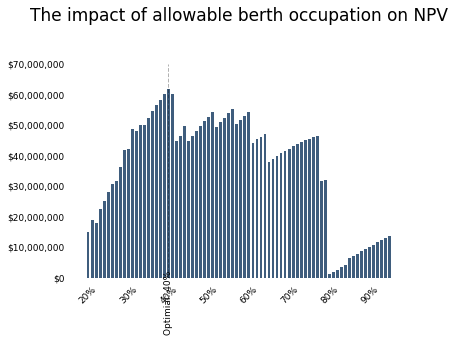

In [6]:
# Visualise NPV distribution 
visualisation.NPV_distribution(iterations)

# 4 Risk Sensitivity Iteration

In [7]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years
end_year          = start_year + simulation_window - 1
operational_hours = 4680   # operational hours per year
allowable_occupancy = 0.40

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Run multiple simulations, each with a different WACC between 5% and 15%
cashflow_list = []
WACC_list = []
WACC_spectrum = range (5, 15, 1)
for sample in WACC_spectrum:
    
    # The WACC
    WACC = sample/100
    
    # Load the initial terminal setup
    terminal = initial.terminal()
    
    # Run simulation
    terminal = simulate(terminal, allowable_occupancy, WACC, vessels, commodities, start_year, simulation_window)
    terminal.trigger = allowable_occupancy
    
    # Save resulting terminal 
    cashflow_list.append(terminal.cashflows)
    WACC_list.append(WACC)

C:\Python\lib\site-packages\plotly\matplotlylib\renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [8]:
#visualisation.risk_sensitivity(cashflow_list, WACC_list)

# 3 Single Simulation Run

In [9]:
# Import existing terminal infrastructure 
terminal = initial.terminal()

# Run simulation
allowable_occupancy = 0.62
WACC = 0.09
terminal = simulate(terminal, allowable_occupancy, WACC, vessels, commodities, start_year, simulation_window)

# Show NPV
print ("NPV: $" + str('{:0,.0f}'.format(terminal.NPV)))

NPV: $45,172,482


# 4 Preliminary Plots

### 4.1 Number of assets throughout the years

In [10]:
#visualisation.asset_trajectory(terminal, simulation_window, start_year)

### 4.2 Revenue / Capex / Opex

In [11]:
%matplotlib inline
visualisation.revenue_capex_opex(terminal)

### 4.3 Profit / Loss

In [12]:
#visualisation.profit_loss_pv(terminal)

### 4.4 Demand vs. Capacity

In [13]:
#visualisation.throughput(terminal, 9,6)

### 4.5 Visualisation of predictive simulator

In [14]:
#visualisation.consecutive_reative_trend(commodities, simulation_window, start_year)
#visualisation.consecutive_predictive_trend(commodities, simulation_window, start_year)